## Lab : Introduction: Python, Numpy, Pandas

# DOCSTRINGS FOR FUNCTIONS

## 1. Time series analysis with pandas

In [1]:
from os import path
import math
import numpy as np
import pandas as pd
import urllib
import zipfile
import sys
import datetime
import matplotlib.pyplot as plt
import random
import timeit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
import time

In [2]:
url = u'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/' 
filename = 'household_power_consumption'
zipfilename = filename + '.zip'
location = url + zipfilename

if not(path.isfile(zipfilename)):
    urllib.request.urlretrieve(location, zipfilename)
        
zipfile.ZipFile(zipfilename).extractall()

na_values = ['?', '']
fields = ['Date', 'Time', 'Global_active_power']
df = pd.read_csv(filename + '.txt', sep=';', nrows=200000,
                 na_values=na_values, usecols=fields)

1) Count the number of lines with missing values. Erase all such lines.

In [3]:
isna = df.loc[:, 'Global_active_power'].isna().sum() 
print(isna / df.shape[0]) # check % of missing rows, here
                          # small enough to erase lines

df.dropna(subset='Global_active_power', inplace=True)
# inplace=True to apply changes directly to dataset

0.01866


2) Use pandas functions to_datetime and set_index to create a Time Series. You should first pre- serve the full date information, i.e. keep the hour, minute, seconds information in your newly created DateTime. Beware, when reading dates, that the international dates format that is different from the French standard.

In [4]:
df.insert(0, 'DateTime', 
            pd.to_datetime(df['Date'] + " " + df["Time"], 
            format="%d/%m/%Y %H:%M:%S")
) # insert new column by merging Date and Time column

df = df.drop(['Date','Time'], axis=1).set_index('DateTime')
# drop old Date and Time column and set new column as index

In [1]:
plt.figure(figsize=(15, 10))
plt.plot(df)
plt.title("Time Series plot of Global active power", fontsize=16)
plt.xlabel("time", fontsize=16)
_= plt.ylabel("Global active power", fontsize=16)

NameError: name 'plt' is not defined

3) Display the graphic of daily averages, between January 1 2007 and April 30 2007. Propose an explanation for the consumption behavior between February and early April.

In [2]:
df_temp = df['2007-01-01':'2007-04-30'] # subset dataset

df_temp.resample("D").mean().plot(style="-o", figsize=(10, 5))
# create and plot daily averages

plt.title(f"Time Series plot of Global active power"
          f" Jan 1 2007 - April 30 2007", fontsize=16)
plt.xlabel("time", fontsize=16)
_= plt.ylabel("Global active power", fontsize=16)

NameError: name 'df' is not defined

The global power consumption oscillates normally until
March, which experienced a steep drop in energy consumption.
This can be due to some external shock, e.g. a steep increase
in prices or supply shortage.

4) Load the dataset with pandas, and keep only the DATE and TG columns. Divide by 10 the TG column to get Celsius temperature. Treat missing values as NaNs.

In [9]:
df4 = pd.read_csv("TG_STAID011249.txt", sep=',', comment='#', usecols=[2, 3])
df4.columns = ['DATE', 'TG'] # rename columns
df4['DATE'] = pd.to_datetime(df4['DATE'], format="%Y%m%d")
df4 = df4.set_index('DATE')

df4['TG'] = df4['TG'].values/10 # calculate Celsuis temperature
df4[df4.isna().any(axis=1)].sum() # check missing values, here none

TG    0.0
dtype: float64

5) Create a pandas Time Series with the daily temperatures between January 1 2007 and April 30 2007. Display on the same graph the temperature and the Global_active_power Time Series. Using a twinx axis might help to display 2 series of values with different magnitudes in a readable fashion.

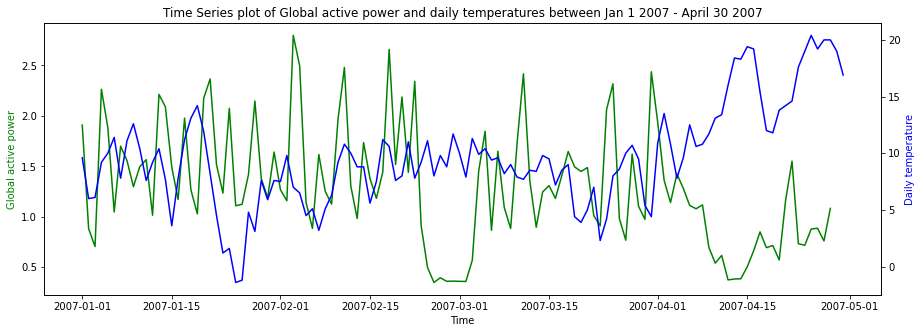

In [10]:
df4_temp = df4['2007-01-01':'2007-04-30'] # subset dataset

x = df4_temp.index
y1 = df_temp.resample("D").mean().iloc[:,0]
y2 = df4_temp.iloc[:,0]

fig, ax1 = plt.subplots(figsize=(15, 5))

ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

ax1.set_xlabel('Time')
ax1.set_ylabel('Global active power', color='g')
ax2.set_ylabel('Daily temperature', color='b')
_= plt.title(f"Time Series plot of Global active power"
          f" and daily temperatures between" 
          f" Jan 1 2007 - April 30 2007", fontsize = 12)

## 2. Linear Algebra

We remind the following linear algebra fact: for any $X \in \mathbb{R}^{nxp}$ and $y \in \mathbb{R}^n$ the following equation
holds true:
$X^T(XX^T + \lambda Id_n)^{-1}y = (X^TX + \lambda Id_p)^{-1}X^Ty$ (Equality 1)

6) Check this property numerically for $λ = 10^{-5}$ without inverting any matrix. To compute $A^{-1}=b$, never invert directly A: solve the linear system Ax = b with np.linalg.solve, for a matrix X whose entries are generated randomly (i.i.d.) according to a Gaussian distribution with mean zero and variance 5, and for a vector y with coordinates generated randomly (i.i.d.) according to a uniform distribution over [-1, 1],

function to compute the term on the left of the equality sign in equality 1 <br> input: X (n x p matrix), y (n x 1 vector) <br> output: result_left - result of left term

In [11]:
def calculate_left(X, y, const_lambda):
    n, _ = X.shape # number of rows in X
    A = np.matmul(X, X.T) + (const_lambda * np.identity(n)) 
    # compute matrix to be inverted
    inverse = np.linalg.solve(A, y) 
    # invert matrix using above-mentioned method
    result_left = np.matmul(X.T, inverse)
    return result_left

function to compute the term on the right of the equality sign in equality 1; input: X (n x p matrix), y (n x 1 vector); output: result_right - result of right term

In [10]:
def calculate_right(X, y, const_lambda):
    _, p = X.shape # number of columns in X
    A = np.matmul(X.T, X) + (const_lambda * np.identity(p)) 
    # compute matrix to be inverted
    b = np.matmul(X.T, y)
    result_right = np.linalg.solve(A, b) 
    # invert matrix using above-mentioned method
    return result_right

Function that creates every element of the equation, calls calculate_right and calculate_left to calculate the result of both terms and also monitors the time both terms need to compute. Then checks if both terms are equal 
<br> input: n - number of rows of X columns of y, p - number of columns of X, const_lambda - constant number <br> output: times_left - array of times it took to compute the left term times_right - array of times it took to compute the right term

In [11]:
def equality_check(n, p, const_lambda):
    times_left = []
    times_right = []
    for i in np.arange(0, len(p), 1): # for-loop to check equality for every p 
        X = np.random.normal(0, math.sqrt(5), size=(n[i], p[i]))
        y = np.random.uniform(low=-1, high=1, size=(n[i]))
        t0_left = time.time() # start time measurement for left term
        left_side = calculate_left(X, y, const_lambda) # compute left term
        t1_left = time.time() # stop time measurement for left term
        time_left = t1_left - t0_left # compute time it took to compute left term
        t0_right = time.time() # start time measurement for right term
        right_side = calculate_right(X, y, const_lambda) # compute right term
        t1_right = time.time() # stop time measurement for right term
        time_right = t1_right - t0_right # compute time it took to compute right term
        equality = np.allclose(left_side, right_side) # check if terms are equal
        print(equality)
        times_left.append(time_left)
        times_right.append(time_right)
    return times_left, times_right

(a) Check it for n=100 and p=2000,

In [12]:
# define all needed constants for task 6a
n = [100]
p = [2000]
const_lambda = 10e-5

In [13]:
_ = equality_check(n, p, const_lambda) 
# call function EqualityCheck for given constants 

True


(b) Check it for n= 2000 and p=100.

In [14]:
# append all needed constants for task 6b
n += [2000]  
p += [100]

In [15]:
_ = equality_check(n, p, const_lambda) 
# call function EqualityCheck for given constants 

True
True


7) For a few scenarios similar to (a) and (b) (n << p, p << n), do a short numerical/graphical study to compare (according to n and p) when it is more time efficient to compute the quantity in (1) using the left hand side formulation or right hand side formulation. Explain the results.

In [16]:
# append all needed constants for task 7
n += [80, 3000, 140, 2600, 30, 5000]
p += [3400, 200, 4200, 40, 1500, 220]
[times_left, times_right] = equality_check(n, p, const_lambda) 
# call function EqualityCheck for given constants and save
# the measured computation times

True
True
True
True
True
True
True
True


In [17]:
d = {'n_values': n, 'p_values': p, 
     'times_left': times_left, 'times_right': times_right}
# create data dictionary with all values of n,
# p, times_left and times_right
df = pd.DataFrame(data=d)
# create data frame with all values of n and p 
# plus the according computation times
df["difference_left_right"] = df["times_left"] - df["times_right"]
# add new column to time frame containing the difference 
# between the computation time of the left term and the right term 
df

,n_values,p_values,times_left,times_right,difference_left_right
0,100,2000,0.000953,0.096496,-0.095543
1,2000,100,0.087822,0.000796,0.087026
2,80,3400,0.000745,0.427095,-0.426350
3,3000,200,0.259060,0.012643,0.246417
4,140,4200,0.002365,0.750552,-0.748187
5,2600,40,0.172144,0.000569,0.171575
6,30,1500,0.000327,0.061024,-0.060697
7,5000,220,1.080018,0.005397,1.074621


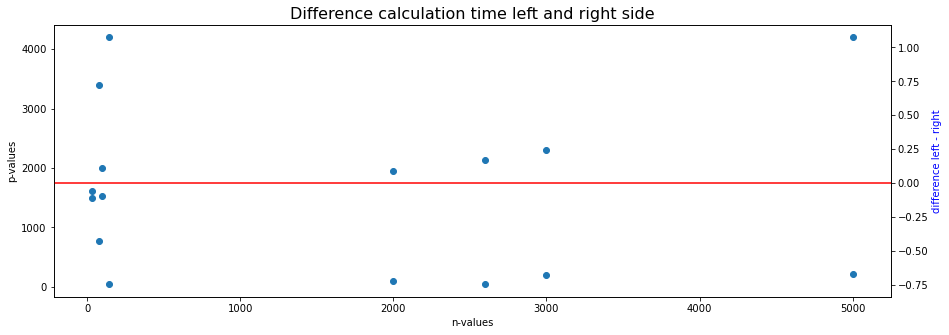

In [18]:
# plot to allow visual understanding of the changement of computing times
# for the different matrices
x = df["n_values"]
y1 = df["p_values"]
y2 = df["difference_left_right"]
fig, ax1 = plt.subplots(figsize=(15, 5)) 
ax2 = ax1.twinx() # create second axis 
# to display two different values spaces on the y axis
ax1.scatter(x, y1)
ax2.scatter(x, y2)
ax1.set_xlabel('n-values')
ax1.set_ylabel('p-values')
ax2.set_ylabel('difference left - right', color='b')
plt.axhline(y = 0, color = 'r', linestyle='-')
plt.title("Difference calculation time left and right side", fontsize=16)
plt.show()

We can cleary see that the computation of the left term is faster if n<p and vice versa.
for small values of p and large values n (see cloud of point near n=0) the difference 
left-right tends to be positive. Thus, the right term takes less time to compute.
For large values of p and small values n (see cloud of point near p=0) the difference 
left-right tends to be negative. Thus, the left term takes less time to compute.
The most costly computations of the two terms in regard to their computation time
is the matrix inversion ($O(n^3)$ with maxtrix n x x). The main difference between the 
two terms is the shape of the matrix that has to be inverted. While in the left term a 
n x n matrix has to be inverted, in the right term, a p x p matrix has to be inverted.
Thus, the left side is slower for large values of n and the right side is smaller for 
large values of p.

## 3. Random Matrix Spectrum

8) Choose three non-Gaussian probability distributions, with mean 0 and variance 2, and write a function that takes as input n, p and the distribution name, and creates a matrix X (n,p) with entries generated (i.i.d.) according to this distribution.

In [12]:
def matrix_generator(n, p, distribution):
    mat_rand = np.zeros((n, p)) # create zero matrix to fill
    
    if distribution == "uniform":
        mat_rand = np.random.uniform(-np.sqrt(6), np.sqrt(6), size=(n, p)) 
        # choose lower and upper bound as sqrt(6) to generate
        # distribution with mean 0 and var 2
    
    if distribution == "logistic":
        mat_rand = np.random.logistic(0, np.sqrt(6/np.pi**2), size=(n, p))
        # define mean=0 and scale such that var=2
        
    if distribution == "laplace":
        mat_rand = np.random.laplace(0, 1, size=(n, p))
        # define mean=0 and scale such that var=2
        
    return mat_rand

9) Display on one single graph the singular values of X for n = 1000, and p = 200, 500, 1000, 2000 for the three distributions chosen.

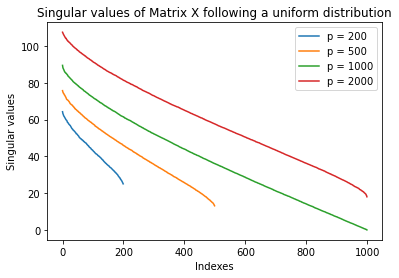

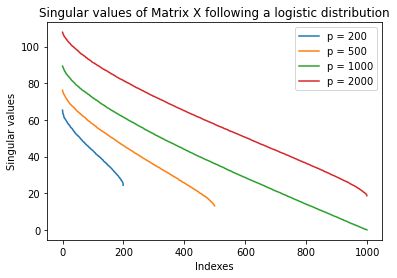

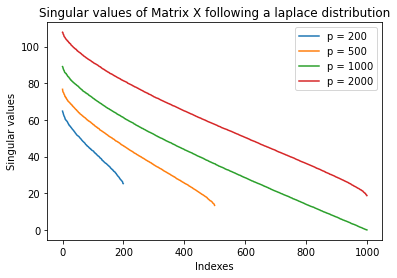

In [13]:
# Set values for n and p
n = 1_000
p_range = [200, 500, 1_000, 2_000]

# Define lists that contain singular values
# for each value of p
singular_values_uniform = []
singular_values_logistic =[]
singular_values_laplace = []

for i in p_range:
    singular_values_uniform.append(
        np.linalg.svd(matrix_generator(n, i, "uniform"))[1]
    )
    singular_values_logistic.append(
        np.linalg.svd(matrix_generator(n, i, "logistic"))[1]
    )
    singular_values_laplace.append(
        np.linalg.svd(matrix_generator(n, i, "laplace"))[1]
    )

# Plot singular values of X for n and p

# Uniform
plt.figure()
for i in range(0, 4):
    plt.plot(singular_values_uniform[i], label=("p = " + str(p_range[i])))
plt.legend()
plt.title("Singular values of Matrix X following a uniform distribution")
plt.xlabel("Indexes")
plt.ylabel("Singular values")

# Logistic
plt.figure()
for i in range(0, 4):
    plt.plot(singular_values_logistic[i], label=("p = " + str(p_range[i])))
plt.legend()
plt.title("Singular values of Matrix X following a logistic distribution")
plt.xlabel("Indexes")
plt.ylabel("Singular values")

# Laplace
plt.figure()
for i in range(0, 4):
    plt.plot(singular_values_laplace[i], label=("p = " + str(p_range[i])))
plt.legend()
plt.title("Singular values of Matrix X following a laplace distribution")
plt.xlabel("Indexes")
_ = plt.ylabel("Singular values")

Note: We note that the singular values across all three distributions are similar as the distributions follow the same mean and variance.

10) Display on one single graph the spectrum (i.e. the set of eigenvalues) of (X.T @ X) / n for n = 1000, and p = 200, 500, 1000, 2000. Comment.

In [14]:
X_uniform, X_logistic, X_laplace = [],[],[]
XT_uniform, XT_logistic, XT_laplace = [],[],[]

for i in range(4):
    # generate matrices with matrix_generator function
    X_uniform.append(matrix_generator(n, p_range[i], "uniform" ))
    X_logistic.append(matrix_generator(n, p_range[i], "logistic" ))
    X_laplace.append(matrix_generator(n, p_range[i], "laplace" ))
    
    # calculate eigenvalues of X.T@X/n and sort in descending order
    XT_uniform.append(np.sort(
        np.linalg.eigvals(X_uniform[i].T @ X_uniform[i] / n))[::-1]
    )
    XT_logistic.append(np.sort(
        np.linalg.eigvals(X_logistic[i].T @ X_logistic[i] / n))[::-1]
    )
    XT_laplace.append(np.sort(
        np.linalg.eigvals(X_laplace[i].T @ X_laplace[i] / n))[::-1]
    )

/Users/tobiastolciu/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/tobiastolciu/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/tobiastolciu/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


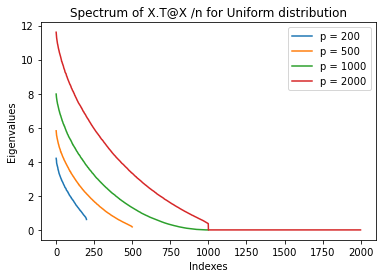

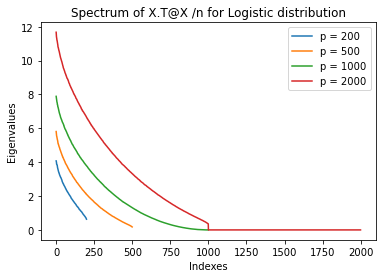

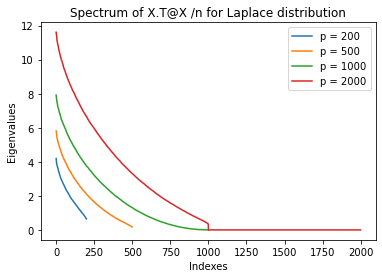

In [15]:
# Plot eigenvalues of X.T@X/n

# Uniform
plt.figure()
for i in range(4):
    plt.plot(XT_uniform[i], label=('p = ' + str(p_range[i])))
plt.legend()
plt.title("Spectrum of X.T@X /n for Uniform distribution")
plt.xlabel("Indexes")
plt.ylabel("Eigenvalues")

# Logistic
plt.figure()
for i in range(4):
    plt.plot(XT_logistic[i], label=('p = ' + str(p_range[i])))
plt.legend()
plt.title("Spectrum of X.T@X /n for Logistic distribution")
plt.xlabel("Indexes")
plt.ylabel("Eigenvalues")

# Laplace
plt.figure()
for i in range(4):
    plt.plot(XT_laplace[i], label=('p = ' + str(p_range[i])))
plt.legend()
plt.title("Spectrum of X.T@X /n for Laplace distribution")
plt.xlabel("Indexes")
_= plt.ylabel("Eigenvalues")

Note: Similarly to above, we note that the eigenvalues across all three distributions are similar as the distributions follow the same mean and variance.

## 4. Power method

11) Write a function coding Algorithm 1.

Function that perform the above-mentioned algorithm
input: X - matrix, T - maximum number of iterations,
p - number of rows of vector v
<br> output: uk - vector u after T iterations
<br> vk - vector v after T iterations

In [17]:
def power_function(X, T, p):
    vk = np.random.rand(p, 1) # initial guess for the eigenvector
    
    for k in range(1, T+1):
        uk = np.matmul(X, vk) / np.linalg.norm(np.matmul(X, vk))
        vk = np.matmul(X.T, uk) / np.linalg.norm(np.matmul(X.T, uk))
        
    return uk, vk

12) Modify the implementation of the algorithm to store all iterates of u and v. Let u* (resp. v*) be the leading left (resp. right) singular vector of X. Compute them using np.linalg.svd. Plot the norm of uk - u* as a function of k. Is it true that the output u, v from the algorithm converge to u*,v*? Run your code several times. Bonus: Can you show it mathematically?

Function that performs the above-mentioned algorithm
<br> input: X - matrix, T - maximum number of iterations,
p - number of rows of vector v
const_lambda - constant number 
<br> output: u - list containing all vectors u after each iterations
v - list containing all vectors u after each iterations

In [18]:
def power_function_store(X, T, p):
    v = [] # empty list to store all vecors v
    u = [] # empty list to store all vecors u
    v.append(np.random.rand(p, 1))

    for k in range(1,T+1):
        u.append(np.matmul(X, v[k-1]) / np.linalg.norm(np.matmul(X, v[k-1])))
        v.append(np.matmul(X.T, u[k-1]) / np.linalg.norm(np.matmul(X.T, u[k-1])))
        
    return u, v 

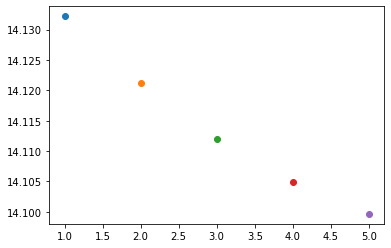

In [19]:
# define variables
n = 100
p = 2_000
T = 5

# generate matrix
X = np.random.normal(0, np.sqrt(5), (n, p))

# conduct singular value decomposition
u, s, vh = np.linalg.svd(X)

# define leading left and right singular vectors
u_leading = u[:, 0]
vh_leading = vh[0, :]

u, v = power_function_store(X, T, p)

# plot norm of u[k] - u for all k
for k in range(0, T, 1):
    plt.scatter(k+1, np.linalg.norm(u[k] - u_leading))

We can cleary see that the Values of u[k] converge towards u[T-1]. This was to be 
expected since the power method does iteratively approximate the largest eigenvalue
of X. Thus, the value of u does get closer (converges) to the largest eigenvalue of X.
When taking a closer look to the power method this can be proven mathimatically. We are working with an (n x p) matrix X which is diagonizable. Thus, the matrix has p linearly independent eigenvectors denoted as ($x_1, ..., x_p$) with corresponding eigenvalues ($\lambda_1,..., \lambda_p$). We assume that the eigenvalues are sorted such that $\lambda_1$ is the largest eigenvalue of X and $x_1$ is the corresponding eigenvector. The power
method starts with guessing a random vector which is hoped to be as close to the eigenvector that
corresponds to the largest eigenvalue as possible. We can write the vector $v_0$ as a linear combination
$v_0 = c_1x_1 + c_2x_2 + ... + c_px_p$ (1) as the eigenvectors of X create a span $\mathbb{R}^{nxp}$. If it turns out that $c_1=0$ another vector $v_0$ has to be choosen. Once v has been determined, the vector
will be iteratively multiplied with the matrix X and this matrix multiplication is divided by its norm 
(normalization): 
$\\ v_1 = \frac{X v_{0}}{\lVert X v_{0} \rVert}$ The iterative approach to repeat this computation k times leads us to: 
$\\ v_k = \frac{X v_{k-1}}{\lVert X v_{k-1} \rVert} = \frac{X X v_{k-2}}{\lVert X X v_{k-2} \rVert} = \space ... \space = \frac{X^k v_0}{\lVert X^k v_0 \rVert}$ 
Under consideration (1) we can write: 
$\\ v_k = \frac{X^k v_{0}}{\lVert X^k v_0 \rVert} = \frac{X^k (c_1x_1 + c_2x_2 + ... + c_px_p}{\lVert X^k (c_1x_1 + c_2x_2 + ... + c_px_p) \rVert} = \frac{c_1X^kx_1 + c_2X^kx_2 + ... + c_pX^kx_p}{\lVert c_1X^kx_1 + c_2X^kx_2 + ... + c_pX^kx_p \rVert}$ Using e.g., $Xx_1 = \lambda_1x_1$ we can rewrite $X^kx_i = {\lambda_i}^kx_i \forall i \in p$: 

$ v_k =  \frac{c_1{\lambda_1}^kx_1 + c_2{\lambda_2}^kx_2 + ... + c_p{\lambda_p}^kx_p}{\lVert {\lambda_1}^kx_1 + c_2{\lambda_2}^kx_2 + ... + c_p{\lambda_p}^kx_p) \rVert} = \frac{\lambda_1^k}{\lvert \lambda_1^k \rvert} \frac{c_1x_1 + c_2(\frac{\lambda_2}{\lambda_1})^kx_2 + ... + c_p(\frac{\lambda_p}{\lambda_1})^kx_p}{\lVert c_1x_1 + c_2(\frac{\lambda_2}{\lambda_1})^kx_2 + ... + c_p(\frac{\lambda_p}{\lambda_1})^kx_p \rVert} \\$
For $ k \rightarrow \infty$ and especially for $\lambda_1 >> \lambda_2,...$ this simplifies to: $ v_k = \frac{\lambda_1^k}{\lvert \lambda_1^k \rvert} \frac{c_1x_1}{\lVert c_1x_1 \rVert} = \frac{x_1}{\lVert x_1 \rVert}$

13) Provide two initialization vectors $v_0$ leading to different limits for this algorithm; explain how they are related.

call power_function_store with the same vector X that 
will lead to two different vectors v0 as the function
randomly generates a new vector for every function call

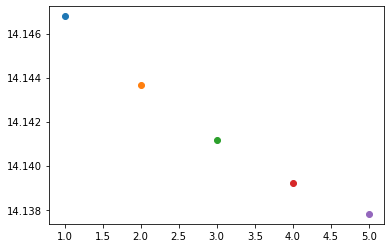

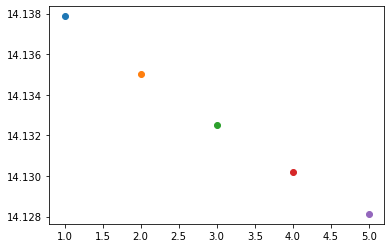

In [21]:
u1, v1 = power_function_store(X, T, p)
for k in range(0, T, 1):
    plt.scatter(k+1, np.linalg.norm(u1[k] - u_leading))
    # plot u_k for every k for first v0
plt.show()
u2, v2 = power_function_store(X, T, p)
for k in range(0, T, 1):
    plt.scatter(k+1, np.linalg.norm(u2[k] - u_leading))
    # plot u_k for every k for first v0

Calling the power method with two different "starting" vectors $v_0$ will a.s. lead to the same result in the long term as has been proven earlier. However, the speed of convergence clearly depends on the degree of difference between $v_0$ and the eigenvector $x_1$ of the largest eigenvalue $\lambda_1$. If $v_0$ is very close to $x_1$ the algorithm will converge really quickly, while vice versa for very differet vectors the algorithm will take lots of iteration to converge. Thus, the different values to which the two function calls seem to converge are explainable due to the relative small number of iterations (T=5). 

14) Provide a way to approximate the largest singular value of X using the power method.

The largest singular value of a matrix is, per definition, equal to the spectral norm of the matrix. As discussed before, the power method can approximately determine the largest eigenvector of a matrix X. Hence, computing the eigenvector of the largest eigenvalue of $X$ using the power method and applying (1) allows us to determine the largest singular value of X.

In [22]:
X_max = np.linalg.norm(X @ power_function(X, 1000, p)[1])
# run power_function with larger amount of iterations to ensure convergence
# compute spectral norm of X using eigenvector
X_max_real = np.linalg.svd(X)[1][0]
# compute largest singular value of X to check result
print(X_max, X_max_real)

123.30643051121064 123.30643051121064


15) Build upon the power method to provide an algorithm that can approximate the second largest
singular value of X (without using an SVD function).

The second largest singular value of X can be approximated by computing X_max2 = $ \lVert Y v_{Y_1} \rVert $. $v_{Y_1}$ is the output of the power method applied to matrix Y. Y is the difference between $X$ and $Xmax*u*v^T$ where X_max is the previous result for the largest singular value of X, u is the result of the power method for X and v ist the result of the power method for $X^T$.

In [23]:
Y = (X - X_max * power_function(X, 1000, p)[0].reshape(n, 1)
     @ power_function(X, 1000, p)[1].reshape(p,1).T) 
# determin Y (use reshape to allow allow multiplication)
X_max2 = np.linalg.norm(Y @ power_function(Y, 1000, p)[1])
# compute second largest singular value of X with power method
X_max2_real = np.linalg.svd(X)[1][1]
# compute second largest singular value of X with built-in method
print(X_max2, X_max2_real)

120.1810818577281 120.1810818577282


## 5. Analysis of the auto-mpg dataset

16) Import the dataset from https://archive.ics.uci.edu/ml/machine-learning-databases/ auto-mpg/auto-mpg.data-original with Pandas. Add columns name using the name parameter of read_csv and consulting: https://archive.ics.uci.edu/ml/machine-learning-databases/ auto-mpg/auto-mpg.names. You can check the impact of using sep=r"\s+". Is there a marker for missing values in this dataset? If needed, remove the corresponding lines. The last column, car name, is not useful for our study: drop it.

In [24]:
# define URL and column names
url_auto = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original' 
auto_names = ['mpg', 'cylinders', 'displacement', 
              'horsepower', 'weight', 'acceleration',
              'model_year', 'origin', 'car_name']

# create and clean dataset
df_auto = pd.read_csv(url_auto, delim_whitespace=True, 
                      header=None, names=auto_names
                     )
df_auto.dropna(inplace=True)
df_auto.reset_index(inplace=True) # reset index after dropping values
df_auto.drop(['car_name', 'index'], inplace=True, axis=1)
df_auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0


17) Add two or three binary features to meaningfully encode the three origins ('origin' feature, for which, initially, 1 stands for USA, 2 for Europe and 3 for Japan).

In [25]:
# insert new column for each geography that is set to 1
# if "origin" contains the corresponding value
df_auto['USA'] = np.where((df_auto['origin'] == 1.0), 1, 0)
df_auto['Europe'] = np.where((df_auto['origin'] == 2.0), 1, 0)
df_auto['Japan'] = np.where((df_auto['origin'] == 3.0), 1, 0)

df_auto.drop(['origin'], inplace=True, axis=1)
df_auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,USA,Europe,Japan
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1,0,0
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1,0,0
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1,0,0
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1,0,0
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1,0,0


18) Select (manually) 9 rows of the dataset such that all 3 origins are represented, and model year is not constant. Get the least-squares estimator θˆ (with intercept) and the prediction vector yˆ, considering only these 9 lines. What do you observe? Why?

In [26]:
df_countries = df_auto.iloc[[0, 1, 2, 14, 19, 20, 29, 31, 49],:]
df_countries

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,USA,Europe,Japan
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1,0,0
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1,0,0
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1,0,0
14,24.0,4.0,113.0,95.0,2372.0,15.0,70.0,0,0,1
19,26.0,4.0,97.0,46.0,1835.0,20.5,70.0,0,1,0
20,25.0,4.0,110.0,87.0,2672.0,17.5,70.0,0,1,0
29,27.0,4.0,97.0,88.0,2130.0,14.5,71.0,0,0,1
31,25.0,4.0,113.0,95.0,2228.0,14.0,71.0,0,0,1
49,28.0,4.0,116.0,90.0,2123.0,14.0,71.0,0,1,0


In [27]:
# define x and y in dataset
df_Xcountries = df_countries.drop(['mpg'], axis=1)
df_Ycountries = df_countries['mpg']

# fit linear regression model on x and y
least_squares = LinearRegression().fit(df_Xcountries, df_Ycountries)

print(least_squares.coef_)
print(least_squares.intercept_)

# calculate prediction vector
mpg_estimate = least_squares.predict(df_Xcountries)
mpg_estimate

[ 2.78014493 -0.09665737  0.04181362 -0.00279055 -0.30328632  0.7260227
  0.69503623  1.03992361 -1.73495984]
-18.168050154558795


array([17.93415871, 14.86559724, 18.20024405, 23.92068301, 26.02366918,
       25.05564781, 26.7274853 , 25.35183169, 27.92068301])

We observe that our predictions are very accurate, which is expected as we are using the same training data for prediction.

19) Now, get the least-squares estimator θˆ and the prediction vector yˆ (with intercept) over the whole dataset, after performing scaling/centering (the columns must have unit standard deviation and zero mean). Which variables seem to best explain gasoline consumption according to your model? Why wouldn’t this answer make sense if the columns were not normalized?

In [29]:
# define x and y in complete dataset
df_Xauto = df_auto.drop(['mpg'], axis=1)
df_Yauto = df_auto['mpg']

# normalize columns of dataset
autoX_norm = (df_Xauto - df_Xauto.mean()) / df_Xauto.std()

# fit linear regression model on normalized data
least_squares_all = LinearRegression().fit(autoX_norm, df_Yauto)

print(least_squares_all.coef_)
print(least_squares_all.intercept_)

# calculate prediction vector
mpg_estimate_all = least_squares_all.predict(autoX_norm)

[-0.83533813  2.50922132 -0.69990262 -5.69981746  0.21823453  2.86236253
 -0.75249898  0.4085692   0.52249702]
23.44591836734694


The variables that seem to best explain gasoline consumptions are the ones with the highest / lowest coefficients: weight, model year, and displacement. Normalizing columns makes the data comparable across columns, therefore the magnitude of the resulting coefficient can be weighted against each other. 

20) Assume you observe a new car with the following values features: (see exercise sheet). Can you predict its consumption in this model? Beware of the year encoding. 

Use a pipeline http://scikit-learn.org/stable/modules/generated/sklearn.pipeline. Pipeline.html for performing the rescaling and the least-squares step consecutively. Comment on the y predicted value for this car.

In [30]:
# define new car features
new_car = np.array([6., 225., 100., 3233., 
                    15.4, 117., 1., 0., 0.]).reshape(1, -1)
# setting 1900 as the initialization year, the year 2017
# corresponds to the value 117

# define pipeline
pipeline = Pipeline([('Scaling', StandardScaler()), ('Regression', LinearRegression())])

# fit pipeline on training data
pipeline.fit(df_Xauto, df_Yauto)

# predict y on new car data
pipeline.predict(new_car)

/Users/tobiastolciu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([53.11965664])

We note that the predicted mpg value is significantly larger than prior predictions (by factor 2). This is due to the fact that model year is the second strongest predictor in our model, which has a strong impact on the new car prediction as the model year is significantly higher. However, this logic is in itself flawed, as a newer car model not neccessarily corresponds to higher consumption (the opposite might even be true). Hence, our current model is not ideally suited for this prediction.